In [ ]:
# Load the data from the Apporto machine to the Colab environment

from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [ ]:
# Read data from a CSV file into a data frame
df = pd.read_csv('Hotel Cancellation.csv')

# Display the first ten rows of the data frame to examine if it is an individual-level data set
df.head(10)

In [ ]:
#Part 1: Data Partition:

from sklearn.model_selection import train_test_split

#Splitting the data into our partitions will return two dataframes, so we must prep like so:
testpart_size = .2
df_partition = df

df_nontestdata, df_testdata = train_test_split(df_partition, test_size = testpart_size, random_state = 1)

df_nontestdata

In [ ]:
def profit_calculation(model, x_value, y_value):
  d_cutoff = 1/2

  decision = list(model.predict_proba(x_value)[:,1] < d_cutoff)   
  y = list(y_value)
  n_obs = len(y)
    
  cum_profit = 0

  for i in range(n_obs):
      if decision[i] == True and y[i] == 1: 
          profit = -2 
      elif decision[i] == True and y[i] == 0: 
          profit = 10 
      elif decision[i] == False and y[i] == 1: 
          profit = 0
      else:
          profit = 8 
      cum_profit = cum_profit + profit 

  average_net_profit = cum_profit / n_obs 
  return average_net_profit

In [ ]:
#Logistic Regression Analysis:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

DV = 'is_canceled'
y = df_nontestdata[DV]
X = df_nontestdata.drop(columns = [DV])

def summary_coef(model_object):
    n_predictors = X.shape[1]
    model_coef = pd.DataFrame(model_object.coef_.reshape(1,n_predictors),columns = X.columns.values)
    model_coef['Intercept'] = model_object.intercept_
    return (model_coef.transpose())

In [ ]:
kfolds=5

min_alpha = .01
max_alpha = 100

max_C = 1/min_alpha
min_C = 1/max_alpha

n_candidates = 5000
c_list= list(np.linspace(min_C, max_C, num = n_candidates))


#Plug in clf_optimal to our previous Logistic model to find the optimal predictors
clf_optimal = LogisticRegressionCV(Cs = c_list,cv=kfolds, penalty = 'l1', scoring='roc_auc',
                                   solver='saga',max_iter=200, random_state=1, n_jobs = -1).fit(X,y)

#Find the optimal selected alpha
print(1/clf_optimal.C_)

[0.10234392]


In [ ]:
#Calculate Performance of Final Selected Model Over Test Partition

#Actual values of the DV in the test partition
y_test_actual = df_testdata[DV]

#Predictor values in the test_partition
X_test = df_testdata.drop(columns = [DV])

#Predicted values of the DV in the test partition
y_test_predicted = clf_optimal.predict(X_test)

n_obs_test = df_testdata.shape[0]

from sklearn import metrics
print(metrics.confusion_matrix(y_test_actual, y_test_predicted))

[[13822  1279]
 [ 3538  5239]]


In [ ]:
#Calculate ROC_ACU score
print(roc_auc_score(y_test_actual, clf_optimal.predict_proba(X_test)[:,1]))

0.8671642726600972


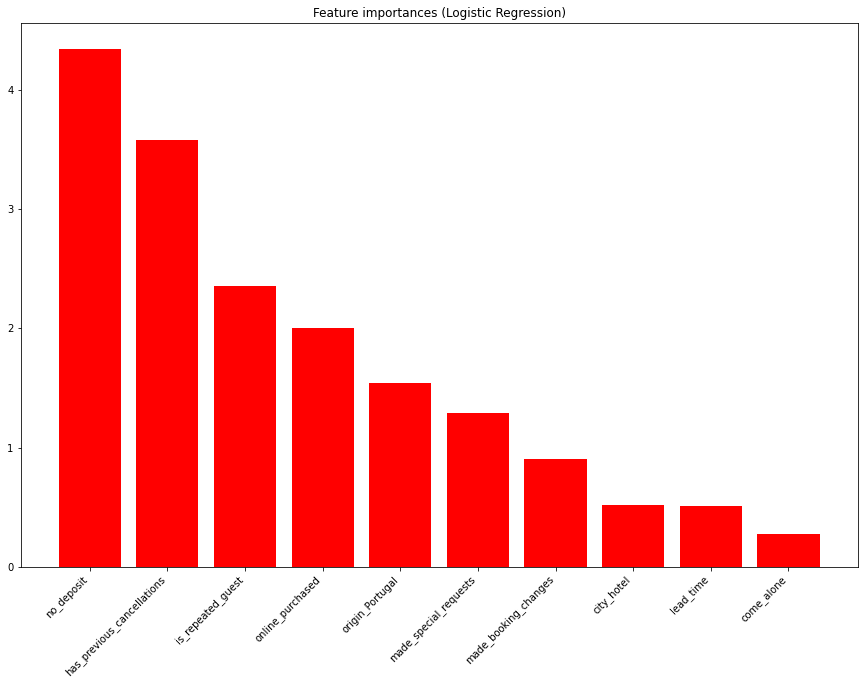

In [ ]:
coefs = np.abs(clf_optimal.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure(figsize=(15,10))
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(10), coefs[indices[:10]],
       color="r", align="center")
plt.xticks(range(10), X.columns[indices[:10]], rotation=45, ha='right')
plt.show()

In [ ]:
# logistic regression that is maximize the average net profit
min_alpha = .01
max_alpha = 100

max_C = 1/min_alpha
min_C = 1/max_alpha

n_candidates = 5000
c_list= list(np.linspace(min_C, max_C, num = n_candidates))


#Plug in clf_optimal to our previous Logistic model to find the optimal predictors
clf_profit = LogisticRegressionCV(Cs = c_list,cv=kfolds, penalty = 'l1', scoring=profit_calculation,
                                   solver='saga',max_iter=200, random_state=1, n_jobs = -1).fit(X,y)

#print the average net profit
print(profit_calculation(clf_profit, X, y))

5.8831769829969005
